In [1]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import glob
from PIL import Image
import torch
from torchvision import transforms

from BC import BC
from ExperienceReplayMemory import RandomDequeMemory

In [21]:
queue_capacity = 100000 
rw_weights = None
batch_size = 64
filename = "MCstso-2.npy"
aux_rm = RandomDequeMemory(queue_capacity, rw_weights, batch_size)
aux_rm.load_rm(filename)

Load Replay memory


In [22]:
aux_rm.set_batch_size(aux_rm.get_memory_size())

In [23]:
states, actions, rewards, next_states, dones = aux_rm.get_batch_for_replay()

In [24]:
states[0].shape

(134,)

In [27]:
state_dim = 128 + 2 + 4#wp
action_space = 2
batch_size = 64
epochs = 10000
n_channel = 3
h_image_in = 80
w_image_in = 160
type_AC = "VAE"
z_dim = 128
beta = 1.0
weights_path= "./weights/segmodel_expert_samples_sem_all.pt"
is_freeze_params = True
linear_layers = []
max_memory_size = 1000000
rw_weights = None,
device = "cuda:0" if torch.cuda.is_available() else "cpu"
wp_encode = False
wp_encoder_size = 64

trainer = BC(states=None, 
             actions=None,
             state_dim=state_dim,
             action_space=action_space,
             batch_size=batch_size,
             epochs=epochs,
             n_channel=n_channel,
             h_image_in=h_image_in,
             w_image_in=w_image_in,
             type_AC=type_AC,
             z_dim=z_dim,
             beta=beta,
             VAE_weights_path=weights_path,
             freeze_params=is_freeze_params,
             linear_layers=linear_layers,
             max_memory_size=max_memory_size,
             rw_weights=rw_weights,
             device=device,
             wp_encode=wp_encode,
             wp_encoder_size=wp_encoder_size)

trainer.replay_memory.create_rm(np.array(states), np.array(actions))

Loading VAE weights..


In [28]:
loss = trainer.update(saved_file="./weights/VAEBCstso-2.pt", get_loss=True)

Text(0.5, 1.0, 'Behavior Cloning Training')

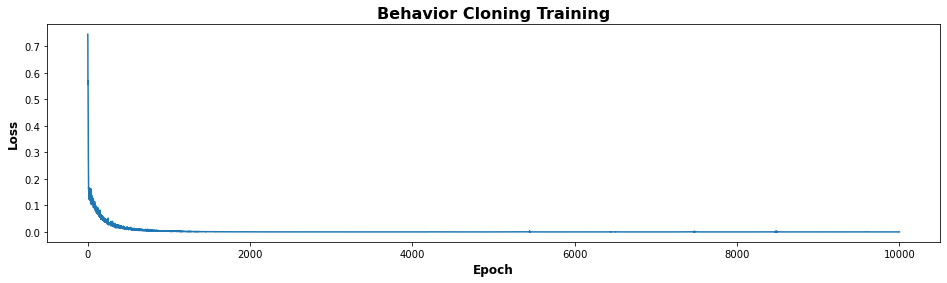

In [29]:
plt.figure(figsize=(16, 4))
plt.plot(loss)
plt.xlabel("Epoch", fontsize=12, fontweight="bold")
plt.ylabel("Loss", fontsize=12, fontweight="bold")
plt.title("Behavior Cloning Training", fontsize=16, fontweight="bold")

In [30]:
actions_pred = None
for i, state in enumerate(states):
    action = trainer.predict(state, extract_feat=False)
    if i == 0:
        actions_pred = action
    else:
        actions_pred = np.vstack((actions_pred, action))

Text(0.5, 0.0, 'Frame')

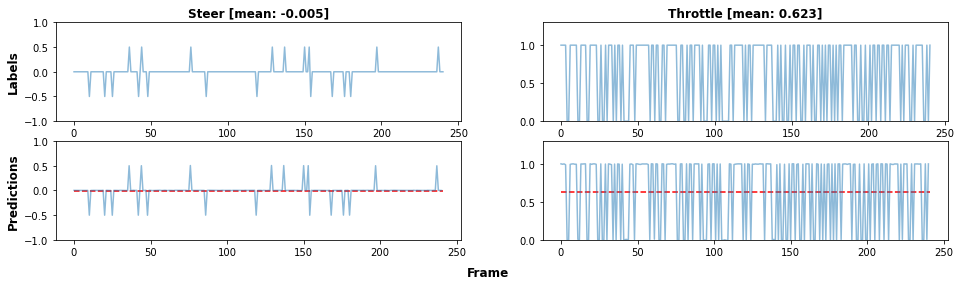

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 4))
axes = axes.flatten()

axes[0].plot(np.array(actions)[:, 0], alpha=.5)
axes[1].plot(np.array(actions)[:, 1], alpha=.5)
axes[2].plot(actions_pred[:, 0], alpha=.5)
axes[3].plot(actions_pred[:, 1], alpha=.5)


mean_steer = np.mean(actions_pred[:, 0])
mean_throttle = np.mean(actions_pred[:, 1])

axes[0].set_title(f"Steer [mean: {mean_steer:.3f}]", fontsize=12, fontweight="bold")
axes[1].set_title(f"Throttle [mean: {mean_throttle:.3f}]", fontsize=12, fontweight="bold")

axes[0].set_ylim([-1.0, 1.0])
axes[1].set_ylim([0, 1.3])
axes[2].set_ylim([-1.0, 1.0])
axes[3].set_ylim([0, 1.3])

axes[0].set_ylabel("Labels", fontsize=12, fontweight="bold")
axes[2].set_ylabel("Predictions", fontsize=12, fontweight="bold")

axes[2].hlines(mean_steer, 0, actions_pred[:, 0].shape[0], linestyles="dashed", colors='red', alpha=1.)
axes[3].hlines(mean_throttle, 0, actions_pred[:, 1].shape[0], linestyles="dashed", colors='red', alpha=1.)

fig.text(0.5, 0., 'Frame', ha='center', fontsize=12, fontweight="bold")